## Heart disease patients clasterization
Tymoteusz Urban, Karolina Mączka

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.filterwarnings("ignore")

### Dividing dataset and saving to files

In [5]:
df = pd.read_csv('heart_disease_patients.csv')

# Split data into train and remaining data
X_train, X_remaining = train_test_split(df, test_size=0.3, random_state=42)

# Split remaining data into test and validation sets
X_test, X_validation = train_test_split(X_remaining, test_size=0.5, random_state=42)

train_df = pd.DataFrame(X_train) 
train_df.to_csv('train.csv', index=False)

test_df = pd.DataFrame(X_test)  
test_df.to_csv('test.csv', index=False)

validation_df = pd.DataFrame(X_validation)
validation_df.to_csv('validation.csv', index=False)


## Data exploration

In [6]:
df = pd.read_csv('train.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df.copy()
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   65    1   1       138   282    1        2      174      0      1.4      2
1   62    1   4       120   267    0        0       99      1      1.8      2
2   57    1   3       150   168    0        0      174      0      1.6      1
3   57    1   4       140   192    0        0      148      0      0.4      2
4   58    0   4       100   248    0        2      122      0      1.0      2


1. age - age in years (male risk > 55, female risk > 65)
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital, 80 norm, 90< overpressure)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false, diabetes)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping, flat is good)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    int64  
 1   sex       212 non-null    int64  
 2   cp        212 non-null    int64  
 3   trestbps  212 non-null    int64  
 4   chol      212 non-null    int64  
 5   fbs       212 non-null    int64  
 6   restecg   212 non-null    int64  
 7   thalach   212 non-null    int64  
 8   exang     212 non-null    int64  
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 18.3 KB


In [9]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64

There are no null values, all variables are clean and properly prepared.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>],
       [<Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>],
       [<Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>,
        <Axes: title={'center': 'exang'}>],
       [<Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>, <Axes: >]], dtype=object)

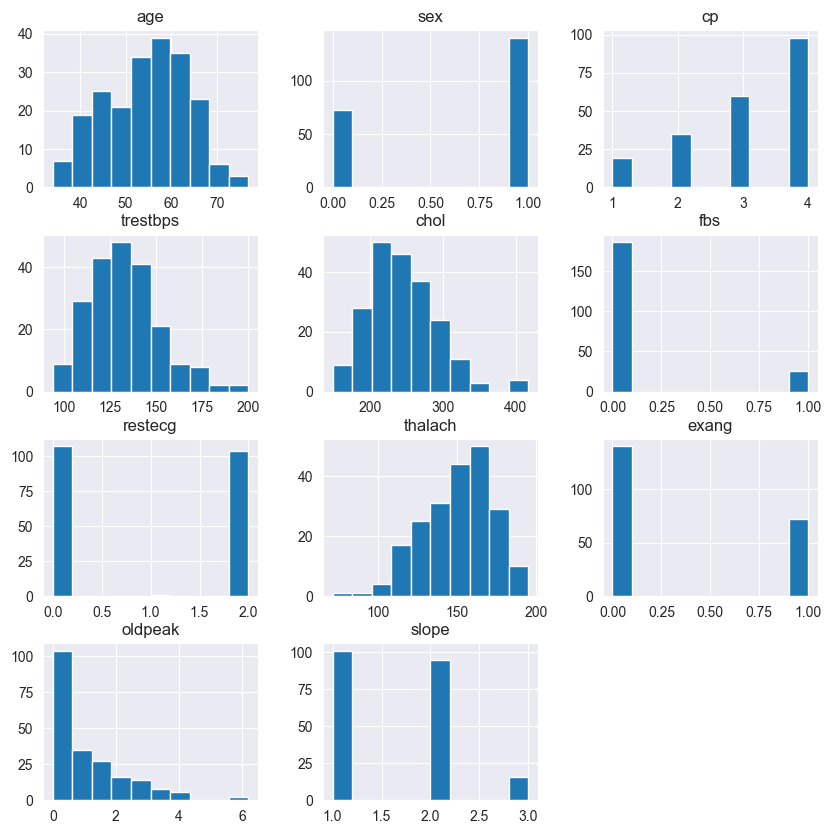

In [6]:
df.hist(figsize=(10,10))

Restecg looks strange as if there were no values 1. Let's check it:

In [7]:
df['restecg'].value_counts()

restecg
0    107
2    104
1      1
Name: count, dtype: int64

There is only one value 1, so we will treat it as an outlier.

<Axes: >

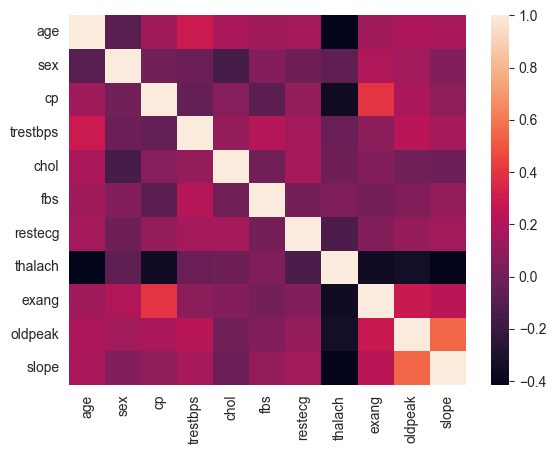

In [8]:
sns.heatmap(df.corr())

There is quite high correlation between oldpeak and slope and also between cp and exang, but is it big enough to delete any of the columns? Also, there is negative correlation between thalach and: age, cp, exang, oldpeak, slope.

In [9]:
print(f"oldpeak and slope correlation: {df[['oldpeak', 'slope']].corr().iloc[0,1]}")
print(f"cp and exang correlation: {df[['cp', 'exang']].corr().iloc[0,1]}")
print(f"thalach and age correlation: {df[['thalach', 'age']].corr().iloc[0,1]}")
print(f"thalach and slope correlation: {df[['thalach', 'slope']].corr().iloc[0,1]}")

oldpeak and slope correlation: 0.5458278072906251
cp and exang correlation: 0.39916290470356114
thalach and age correlation: -0.4149739322362583
thalach and slope correlation: -0.40644733868269406


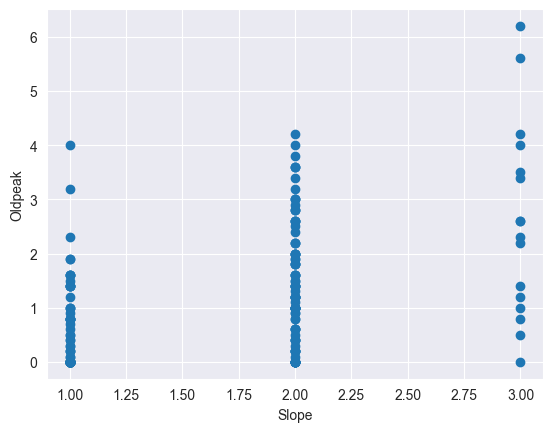

In [10]:
plt.scatter(df['slope'], df['oldpeak'])
plt.xlabel('Slope')
plt.ylabel('Oldpeak')
plt.show()

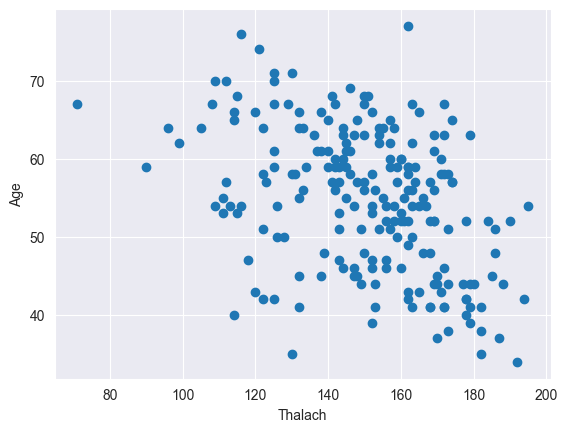

In [11]:
plt.scatter(df['thalach'], df['age'])
plt.xlabel('Thalach')
plt.ylabel('Age')
plt.show()

In [12]:
# Another approach
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [13]:
calc_vif(df)

,variables,VIF
0,age,39.346948
1,sex,3.095046
2,cp,12.426015
3,trestbps,58.483209
4,chol,29.128519
5,fbs,1.200710
6,restecg,2.136638
7,thalach,34.543369
8,exang,2.081073
9,oldpeak,2.720192


Which variables should we drop? According to traditional correlation between variables it could be slope, but after calculating VIF it seems that age, trestbps, chol and thalach are highly correlated with the other variables. So from both methods thalach column is a candidate to delete.

## Preprocessing

In [7]:
# Outliers removal - replace lower_bound and upper_bound, only numeric columns
def replace_outliers(data, k=1.5):
    """
    Removes outliers from a pandas DataFrame using the interquartile range (IQR) method.

    :param data: dataframe
    :param k: A multiplier to adjust the outlier threshold. By default, k is set to 1.5.
    :return: dataframe
    """
    data = data.copy()
    for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (data[col] < lower_bound)
        data.loc[mask, col] = lower_bound
        mask = (data[col] > upper_bound)
        data.loc[mask, col] = upper_bound

    value = data['restecg'].value_counts().idxmax()
    data['restecg'] = data['restecg'].replace(1, value)
    data['restecg'] = data['restecg'].replace(2, 1) # make restecg a boolean column: 1 means hypertrophy, 0 is normal

    return data

In [8]:
#  Encode chest pain type column
def encode_columns(data):
    """
        Encodes categorical column cp (chest pain type)

    :param data: Dataframe
    :return: Encoded dataframe
    """
    data = data.copy()
    data = pd.get_dummies(data, columns=['cp'], prefix='cp', dtype=int)
    data = data.rename(columns={"cp_1": "cp_typ_ang", "cp_2": "cp_atyp_ang", "cp_3": "cp_non_ang", "cp_4": "cp_asympt"})
    return data

In [9]:
# Instead manual deletion of variables we could use PCA for reducing dimensionality
def remove_overshadowing(data):
    """
    Performs Principal Component Analysis (PCA) on a given dataset.

    :param data: dataframe
    :return:
            A reduced version of the input DataFrame, containing the first n principal components
            where n is the smallest number of components that explain at least 95% of the variance in the data.
            The columns of the new DataFrame are named "PC1", "PC2", etc.

    """
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(data)

    # Determine the number of principal components to retain
    explained_variances = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variances)
    n_components = np.argmax(cumulative_variances > 0.95) + 1

    # Retain the first n principal components
    X_reduced = X_pca[:, :n_components]

    # Convert back to a pandas DataFrame
    df_reduced = pd.DataFrame(X_reduced, columns=["PC"+str(i) for i in range(1, n_components+1)])
    
    return df_reduced

We will also need to scale our data - we can try 3 different ways to do it. We will test it later.

In [10]:
def standarize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X


def normalize(X):
    normalizer = Normalizer()
    X_normalized = normalizer.fit_transform(X)
    X = pd.DataFrame(X_normalized, columns=X.columns)
    return X


def minmax(X):
    minmaxer = MinMaxScaler()
    X_scaled = minmaxer.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X

In [18]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,65,1,1,138,282,1,2,174,0,1.4,2
1,62,1,4,120,267,0,0,99,1,1.8,2
2,57,1,3,150,168,0,0,174,0,1.6,1
3,57,1,4,140,192,0,0,148,0,0.4,2
4,58,0,4,100,248,0,2,122,0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
207,54,1,2,192,283,0,2,195,0,0.0,1
208,67,1,4,125,254,1,0,163,0,0.2,2
209,59,1,4,140,177,0,0,162,1,0.0,1
210,61,1,4,140,207,0,2,138,1,1.9,1


In [11]:
# testing pca
from preprocessing import remove_id, preprocessing
df_test = preprocessing(df, process='minmax')
df_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.132617,0.426787,0.433962,0.891037,0.798188,-0.388303,0.527402,0.477042,-0.117244,-0.160859
1,0.910406,-0.637786,0.181633,-0.365014,0.062484,0.035384,-0.166866,-0.103250,0.145059,-0.310922
2,-0.799262,-0.282356,0.649245,-0.174409,-0.256103,-0.225534,-0.086299,-0.021977,0.214752,0.316420
3,0.282105,-0.522200,-0.096707,-0.033347,-0.163912,-0.664081,-0.012473,-0.203405,0.036688,-0.112053
4,0.382437,0.677170,-0.691201,-0.180314,-0.086393,-0.344277,-0.123727,-0.218404,-0.274267,-0.327804
...,...,...,...,...,...,...,...,...,...,...
207,-0.465364,0.065390,-0.357721,1.063195,-0.126054,0.416202,0.122289,-0.048420,0.456757,0.366300
208,0.248736,-0.460210,0.045179,-0.020140,0.167596,-0.678671,0.897341,-0.256596,-0.059555,-0.280164
209,0.645060,-0.750013,0.022189,-0.262070,-0.342125,0.113274,0.166023,0.338142,0.042257,0.007272
210,1.006905,0.098332,0.118930,0.163508,-0.322555,0.266672,0.046522,0.172808,0.122399,0.143866


In [12]:
# Let's check our functions
df_prep = replace_outliers(raw_data)
df_prep = encode_columns(df_prep)
df_prep

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_typ_ang,cp_atyp_ang,cp_non_ang,cp_asympt
0,65.0,1,138.00,282.0,1,1,174.0,0,1.4,2,1,0,0,0
1,62.0,1,120.00,267.0,0,0,99.0,1,1.8,2,0,0,0,1
2,57.0,1,150.00,168.0,0,0,174.0,0,1.6,1,0,0,1,0
3,57.0,1,140.00,192.0,0,0,148.0,0,0.4,2,0,0,0,1
4,58.0,0,100.00,248.0,0,1,122.0,0,1.0,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,54.0,1,171.25,283.0,0,1,195.0,0,0.0,1,0,1,0,0
208,67.0,1,125.00,254.0,1,0,163.0,0,0.2,2,0,0,0,1
209,59.0,1,140.00,177.0,0,0,162.0,1,0.0,1,0,0,0,1
210,61.0,1,140.00,207.0,0,1,138.0,1,1.9,1,0,0,0,1


In [13]:
minmax(df_prep)

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_typ_ang,cp_atyp_ang,cp_non_ang,cp_asympt
0,0.720930,1.0,0.569579,0.617169,1.0,1.0,0.793103,0.0,0.350,0.5,1.0,0.0,0.0,0.0
1,0.651163,1.0,0.336570,0.547564,0.0,0.0,0.054187,1.0,0.450,0.5,0.0,0.0,0.0,1.0
2,0.534884,1.0,0.724919,0.088167,0.0,0.0,0.793103,0.0,0.400,0.0,0.0,0.0,1.0,0.0
3,0.534884,1.0,0.595469,0.199536,0.0,0.0,0.536946,0.0,0.100,0.5,0.0,0.0,0.0,1.0
4,0.558140,0.0,0.077670,0.459397,0.0,1.0,0.280788,0.0,0.250,0.5,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.465116,1.0,1.000000,0.621810,0.0,1.0,1.000000,0.0,0.000,0.0,0.0,1.0,0.0,0.0
208,0.767442,1.0,0.401294,0.487239,1.0,0.0,0.684729,0.0,0.050,0.5,0.0,0.0,0.0,1.0
209,0.581395,1.0,0.595469,0.129930,0.0,0.0,0.674877,1.0,0.000,0.0,0.0,0.0,0.0,1.0
210,0.627907,1.0,0.595469,0.269142,0.0,1.0,0.438424,1.0,0.475,0.0,0.0,0.0,0.0,1.0


<Axes: >

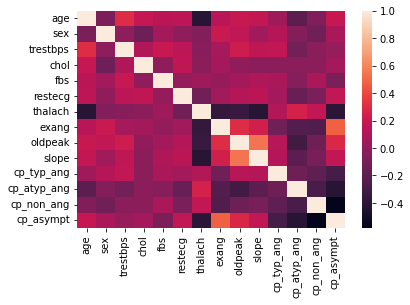

In [14]:
sns.heatmap(df_prep.corr())

## Number of clusters

In [15]:
# We will use functions from other python files, so we don't have to run whole notebook every time
from preprocessing import standarize, minmax, normalize, replace_outliers, preprocessing
from KMeans import k_means_alg

First we prepare methods for finding optimal number of clusters

In [16]:
def num_of_clus_elbow(data) -> int:
    """
        Finds optimal number of clusters using elbow method.

        :param data: dataframe
        :return: number of clusters
    """
    sum_of_squared_distances = []
    K = range(1, 10)
    for num_clusters in K:
        kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)

    # finding elbow point
    sd = np.diff(sum_of_squared_distances, 2)
    elbow_point = np.argmax(sd) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 10), sum_of_squared_distances, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return elbow_point

In [17]:
def num_of_clus_silhouette(data) -> int:
    """
    Finds optimal number of clusters using silhouette method.

    :param data: dataframe
    :return: number of clusters
    """
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    silhouette_point = np.argmax(silhouette_scores) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

    return silhouette_point

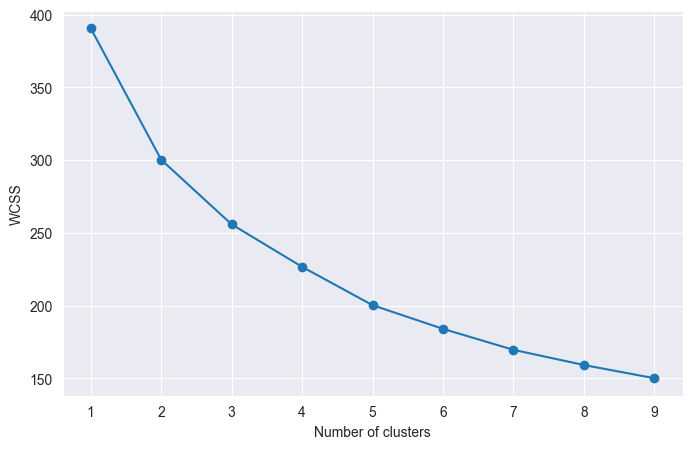

Elbow method: 2


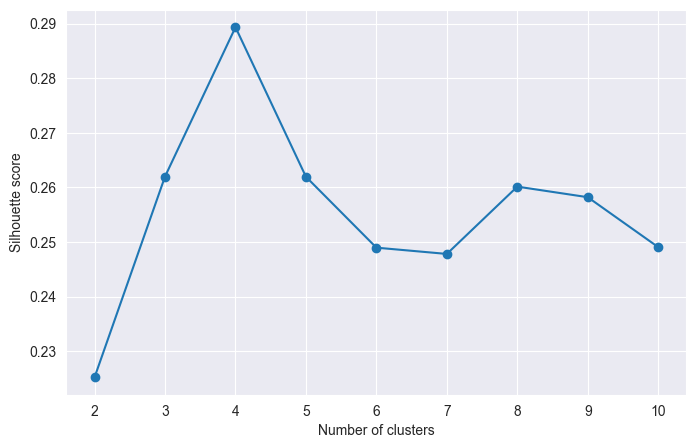

Silhouette method: 4


In [29]:
# Let's check elbow method
df_clusters = replace_outliers(raw_data)
df_clusters = encode_columns(df_clusters)
df_clusters = minmax(df_clusters)
print('Elbow method:', num_of_clus_elbow(df_clusters))
print('Silhouette method:', num_of_clus_silhouette(df_clusters))

We can see that returned values are different. Now we can test it on a baseline model:

In [30]:
for i in [2,4]:
    dfkmeans, model = k_means_alg(df_clusters, num_clusters=i)
    y_kmeans = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_clusters, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_clusters, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_clusters, y_kmeans)}")

number of clusters: 2
silhouette score: 0.2252351224166828
calinski harabasz score: 63.206479218442425
davies bouldin score: 1.776141266296717
number of clusters: 4
silhouette score: 0.28933192733131985
calinski harabasz score: 50.14316823419269
davies bouldin score: 1.3579874845603592


We can see that results are better for 4 clusters. Now let's check how preprocessing influences clusters and score.

In [18]:
processing = ['stand', 'minmax', 'norm']
for proc in processing:
    print(f'Processing: {proc}')
    df_proc = preprocessing(raw_data, rem_over=False, process=proc)
    dfkmeans, model = k_means_alg(df_proc, num_clusters=4)
    y = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_proc, y)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_proc, y)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_proc, y)}")

Processing: stand
Number of clusters: 4
silhouette score: 0.22034126555501474
calinski harabasz score: 36.26326074278857
davies bouldin score: 1.6473047994165644
Processing: minmax
Number of clusters: 4
silhouette score: 0.28933192733131985
calinski harabasz score: 50.14316823419269
davies bouldin score: 1.3579874845603588
Processing: norm
Number of clusters: 4
silhouette score: 0.3012481559184208
calinski harabasz score: 138.60587153808743
davies bouldin score: 0.972272435080523


Results vary depending on processing used. Normalizer has the best results, but we can see that normalized data is hard to interpret:

In [32]:
normalize(raw_data).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.178178,0.002741,0.002741,0.378285,0.773018,0.002741,0.005482,0.476968,0.000000,0.003838,0.005482
1,0.196692,0.003172,0.012690,0.380695,0.847046,0.000000,0.000000,0.314073,0.003172,0.005710,0.006345
2,0.196362,0.003445,0.010335,0.516742,0.578751,0.000000,0.000000,0.599421,0.000000,0.005512,0.003445
3,0.199493,0.003500,0.014000,0.489983,0.671977,0.000000,0.000000,0.517983,0.000000,0.001400,0.007000
4,0.193573,0.000000,0.013350,0.333747,0.827693,0.000000,0.006675,0.407171,0.000000,0.003337,0.006675


For example values in sex column are around 0.003 while in chol or thalach values are way bigger. Thus, minmax scaler is the most reasonable scaler.

In [33]:
df_minmax = preprocessing(raw_data, rem_over=False, process='minmax')
for i in [2, 3, 4, 5, 6]:
    dfkmeans, _ = k_means_alg(df_minmax, num_clusters=i)
    y_kmeans = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_minmax, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_minmax, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_minmax, y_kmeans)}")

number of clusters: 2
silhouette score: 0.2252351224166828
calinski harabasz score: 63.206479218442425
davies bouldin score: 1.776141266296717
number of clusters: 3
silhouette score: 0.2619917170741527
calinski harabasz score: 55.036755233776915
davies bouldin score: 1.7163185655814541
number of clusters: 4
silhouette score: 0.28933192733131985
calinski harabasz score: 50.14316823419269
davies bouldin score: 1.3579874845603592
number of clusters: 5
silhouette score: 0.2619434072133079
calinski harabasz score: 49.159240451761214
davies bouldin score: 1.5078377776890293
number of clusters: 6
silhouette score: 0.24896222620484482
calinski harabasz score: 45.689451854895545
davies bouldin score: 1.5816799409656925


On average the more clusters the better the results, but we have to draw a line somewhere and pick apropriate number of clusters (4 looks the best). Last question is if we should use PCA for reducing dimensionality.

In [34]:
df_pca = preprocessing(raw_data, process='stand')
dfkmeans, model = k_means_alg(df_pca, num_clusters=4)
y_kmeans = dfkmeans['label']
print(f"silhouette score: {silhouette_score(df_pca, y_kmeans)}")
print(f"calinski harabasz score: {calinski_harabasz_score(df_pca, y_kmeans)}")
print(f"davies bouldin score: {davies_bouldin_score(df_pca, y_kmeans)}")

number of clusters: 4
silhouette score: 0.22815791836780464
calinski harabasz score: 37.771413609812384
davies bouldin score: 1.6161708068507368


The scores are way worse. Maybe it is easier to visualize clustering as we only have 3 variables, but we lose interpretability which is crucial in medical data analysis. That said in preprocessing we will stick to minmax scaler and outliers removal, and we will be using 4 clusters.

## Algorithms

In [3]:
from metrices import metrices
from dbscan import dbscan
from Evaluation import medians_for_clusters
from preprocessing import preprocessing
from KMeans import k_means_alg
from other_algorithms import k_medoids_alg, aglomerative_alg, minibatch_alg, gmm_alg

In [4]:
df = pd.read_csv('train.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df.copy()
df = preprocessing(raw_data, rem_over=False, process='minmax')
columns=['method', 'min dist btw cl', 'avg dist in cl', 'std dev dist in cl', 'silhouette', 'cal-har', 'dav-bou']
results = pd.DataFrame(columns=columns)

### Kmeans

In [5]:
results_df = ['Kmeans']

df_kmeans, model = k_means_alg(df, num_clusters=4)
y_kmeans = df_kmeans['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_kmeans)}')
    results_df.append(round(metrices[metric](df, y_kmeans), 3))
print("-----")
print("Medians:")
df_kmeans_medians = raw_data.copy()
df_kmeans_medians['label'] = y_kmeans
print(medians_for_clusters(df_kmeans_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Number of clusters: 4
Minimal distance between clusters: 1.4145219177518047
Average distance between points in the same class: 1.3983463783617291
Standard deviation of distance between points in the same class: 0.07846418170919425
Silhouette score: 0.28933192733131985
Calinski-Harabasz index: 50.14316823419269
Davies Bouldin index: 1.3579874845603588
-----
Medians:
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
0      52.0  1.0  2.0     128.0  235.0  0.0      0.0    164.0    0.0      0.0   
1      58.0  1.0  4.0     130.0  246.5  0.0      2.0    143.0    1.0      1.1   
2      53.5  1.0  3.0     130.0  237.5  0.0      0.0    157.0    0.0      0.4   
3      59.0  1.0  1.0     145.0  234.0  0.0      2.0    162.0    0.0      1.2   

       slope  
label         
0        1.0  
1        2.0  
2        1.0  
3        2.0  


### KMedoids

In [6]:
# results_df = ['KMedoids']

# df_medoids, model = k_medoids_alg(df, num_clusters=4)
# y_kmedoids = df_medoids['label']

# for metric in metrices:
#     print(f'{metric}: {metrices[metric](df, y_kmedoids)}')
#     results_df.append(round(metrices[metric](df, y_kmedoids), 3))
# df_medoids_medians = raw_data.copy()
# df_medoids_medians['label'] = y_kmedoids
# print(medians_for_clusters(df_medoids_medians))

# a = np.array(results_df)
# results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Number of clusters: 4
Minimal distance between clusters: 0.5586623460130081
Average distance between points in the same class: 1.52240259492257
Standard deviation of distance between points in the same class: 0.1046167586375951
Silhouette score: 0.14515839681917014
Calinski-Harabasz index: 31.57869582172508
Davies Bouldin index: 2.387749509330547
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak   
label                                                                           
0      61.0  1.0  4.0     140.0  249.0  0.0      2.0    145.0    0.0     1.40  \
1      58.0  1.0  4.0     132.0  251.0  0.0      2.0    140.0    1.0     1.45   
2      52.0  1.0  3.0     130.0  233.5  0.0      0.0    162.0    0.0     0.20   
3      51.0  1.0  4.0     126.5  231.0  0.0      2.0    168.5    0.0     0.00   

       slope  
label         
0        2.0  
1        2.0  
2        1.0  
3        1.0  


### Mini Batch

In [7]:
results_df = ['Mini Batch']

df_mini, model = minibatch_alg(df, num_clusters=4)
y_mini = df_mini['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_mini)}')
    results_df.append(round(metrices[metric](df, y_mini), 3))

df_mini_medians = raw_data.copy()
df_mini_medians['label'] = y_mini
print(medians_for_clusters(df_mini_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 1.4145219177518047
Average distance between points in the same class: 1.3983463783617291
Standard deviation of distance between points in the same class: 0.07846418170919425
Silhouette score: 0.28933192733131985
Calinski-Harabasz index: 50.14316823419271
Davies Bouldin index: 1.3579874845603592
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak   
label                                                                           
0      53.5  1.0  3.0     130.0  237.5  0.0      0.0    157.0    0.0      0.4  \
1      58.0  1.0  4.0     130.0  246.5  0.0      2.0    143.0    1.0      1.1   
2      52.0  1.0  2.0     128.0  235.0  0.0      0.0    164.0    0.0      0.0   
3      59.0  1.0  1.0     145.0  234.0  0.0      2.0    162.0    0.0      1.2   

       slope  
label         
0        1.0  
1        2.0  
2        1.0  
3        2.0  


### Aglomerative clustering

In [8]:
### DBSCAN

Number of clusters: 4
Minimal distance between clusters: 1.4145219177518047
Average distance between points in the same class: 1.3983463783617294
Standard deviation of distance between points in the same class: 0.07846418170919425
Silhouette score: 0.28933192733131985
Calinski-Harabasz index: 50.14316823419271
Davies Bouldin index: 1.3579874845603592
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak   
label                                                                           
0      58.0  1.0  4.0     130.0  246.5  0.0      2.0    143.0    1.0      1.1  \
1      59.0  1.0  1.0     145.0  234.0  0.0      2.0    162.0    0.0      1.2   
2      53.5  1.0  3.0     130.0  237.5  0.0      0.0    157.0    0.0      0.4   
3      52.0  1.0  2.0     128.0  235.0  0.0      0.0    164.0    0.0      0.0   

       slope  
label         
0        2.0  
1        2.0  
2        1.0  
3        1.0  
Number of clusters: 4
Minimal distance between clusters: 1.15092585719

In [10]:
results_df = ['DBSCAN']

df_dbscan, model = dbscan(df, 'minmax')
y_dbscan = df_dbscan['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_dbscan)}')
    results_df.append(round(metrices[metric](df, y_dbscan), 3))

df_dbscan_medians = raw_data.copy()
df_dbscan_medians['label'] = y_dbscan
print(medians_for_clusters(df_dbscan_medians))

a = np.array(results_df)
# results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 0.5023288445684305
Average distance between points in the same class: 0.541278533832273
Standard deviation of distance between points in the same class: 0.34209161901336566
Silhouette score: 0.023534480044998186
Calinski-Harabasz index: 6.974848916524463
Davies Bouldin index: 1.3605032129296093
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
-1     59.0  1.0  3.0     134.5  233.0  0.0      0.0    152.0    0.0     1.00   
 0     59.0  1.0  4.0     120.0  265.0  0.0      0.0    124.0    1.0     2.90   
 1     53.0  0.0  4.0     102.0  264.0  0.0      2.0    122.0    0.0     0.60   
 2     56.0  1.0  4.0     126.0  262.5  0.0      2.0    125.5    1.0     2.10   
 3     50.5  1.0  3.0     139.0  233.5  0.0      2.0    169.0    0.0     0.80   
 4     44.0  1.0  2.0     120.0  261.0  0.0      0.0    158.0    0.0     0.00   
 5     54.0  1.0  2.0

In [268]:
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_typ_ang,cp_atyp_ang,cp_non_ang,cp_asympt
0,0.720930,1.0,0.569579,0.617169,1.0,1.0,0.793103,0.0,0.350,0.5,1.0,0.0,0.0,0.0
1,0.651163,1.0,0.336570,0.547564,0.0,0.0,0.054187,1.0,0.450,0.5,0.0,0.0,0.0,1.0
2,0.534884,1.0,0.724919,0.088167,0.0,0.0,0.793103,0.0,0.400,0.0,0.0,0.0,1.0,0.0
3,0.534884,1.0,0.595469,0.199536,0.0,0.0,0.536946,0.0,0.100,0.5,0.0,0.0,0.0,1.0
4,0.558140,0.0,0.077670,0.459397,0.0,1.0,0.280788,0.0,0.250,0.5,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.465116,1.0,1.000000,0.621810,0.0,1.0,1.000000,0.0,0.000,0.0,0.0,1.0,0.0,0.0
208,0.767442,1.0,0.401294,0.487239,1.0,0.0,0.684729,0.0,0.050,0.5,0.0,0.0,0.0,1.0
209,0.581395,1.0,0.595469,0.129930,0.0,0.0,0.674877,1.0,0.000,0.0,0.0,0.0,0.0,1.0
210,0.627907,1.0,0.595469,0.269142,0.0,1.0,0.438424,1.0,0.475,0.0,0.0,0.0,0.0,1.0


### GMM

In [11]:
results_df = ['GMM']

df_gmm, model = gmm_alg(df, n_components=4)
y_gmm = df_gmm['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_gmm)}')
    results_df.append(round(metrices[metric](df, y_gmm), 3))

df_gmm_medians = raw_data.copy()
df_gmm_medians['label'] = y_gmm
print(medians_for_clusters(df_gmm_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 1.0278393875244871
Average distance between points in the same class: 1.4009909735560893
Standard deviation of distance between points in the same class: 0.12012748111101124
Silhouette score: 0.23954715824655798
Calinski-Harabasz index: 49.28175280413726
Davies Bouldin index: 1.7463744922608242
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak   
label                                                                           
0      53.5  1.0  3.0     130.0  237.5  0.0      0.0    157.0    0.0     0.40  \
1      59.0  1.0  4.0     130.0  240.0  0.0      2.0    154.0    0.0     1.00   
2      57.5  1.0  4.0     132.0  247.5  0.0      2.0    140.0    1.0     1.55   
3      52.0  1.0  2.0     128.0  235.0  0.0      0.0    164.0    0.0     0.00   

       slope  
label         
0        1.0  
1        2.0  
2        2.0  
3        1.0  


In [270]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=4)
y_sc = sc.fit_predict(df_hier)
for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_sc)}')

Minimal distance between clusters: 1.039150425450418
Average distance between points in the same class: 1.387038953858048
Standard deviation of distance between points in the same class: 0.08881290366723898
Silhouette score: 0.27866864332529495
Calinski-Harabasz index: 48.11995116234483
Davies Bouldin index: 1.3674831790809647


In [65]:
results

,method,min dist btw cl,avg dist in cl,std dev dist in cl,silhouette,cal-har,dav-bou
0,Kmeans,1.415,1.398,0.078,0.289,50.143,1.358
1,Mini Batch,1.024,1.383,0.157,0.214,46.549,1.71
2,Agl Clust,1.415,1.398,0.078,0.289,50.143,1.358
3,GMM,1.028,1.439,0.07,0.221,45.526,1.841


Hierarchical clustering with kmeans

Standard hierarchical clustering

In [272]:
from scipy.cluster.hierarchy import fcluster
from tabulate import tabulate

data = df.to_numpy()

k = 4
linkage_methods = ['single', 'complete', 'average', 'ward']
columns=['min dist btw cl', 'avg dist in cl', 'std dev dist in cl', 'silhouette', 'cal-har', 'dav-bou']

results = []
for method in linkage_methods:
    Z = linkage(data, method=method)
    labels = fcluster(Z, k, criterion='maxclust')

    row = [method]
    for metric in metrices:
        value = metrices[metric](df_hier, labels)
        row.append(value)
    results.append(row)

headers = ['Linkage Method'] + list(columns)
print(tabulate(results, headers=headers, tablefmt='fancy_grid'))

╒══════════════════╤═══════════════════╤══════════════════╤══════════════════════╤══════════════╤═══════════╤═══════════╕
│ Linkage Method   │   min dist btw cl │   avg dist in cl │   std dev dist in cl │   silhouette │   cal-har │   dav-bou │
╞══════════════════╪═══════════════════╪══════════════════╪══════════════════════╪══════════════╪═══════════╪═══════════╡
│ single           │           1.38479 │          1.32463 │            0.0786854 │     0.311868 │   54.8556 │   1.29606 │
├──────────────────┼───────────────────┼──────────────────┼──────────────────────┼──────────────┼───────────┼───────────┤
│ complete         │           1.38479 │          1.32463 │            0.0786854 │     0.311868 │   54.8556 │   1.29606 │
├──────────────────┼───────────────────┼──────────────────┼──────────────────────┼──────────────┼───────────┼───────────┤
│ average          │           1.38479 │          1.32463 │            0.0786854 │     0.311868 │   54.8556 │   1.29606 │
├──────────────────┼────

Dendogram

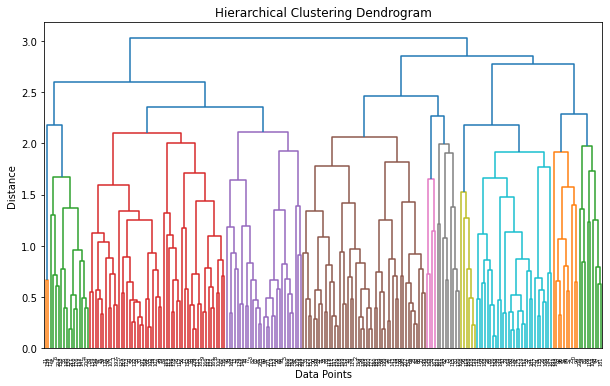

In [273]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

data = df.to_numpy()

Z = linkage(data, method='complete')

plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

Hybrid with Kmeans

In [274]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances_argmin_min

k=4
agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='single')
agg_labels = agg_cluster.fit_predict(df)

# Compute the center of each cluster
cluster_centers = []
for cluster in range(k):
    cluster_data = df[agg_labels == cluster]
    cluster_center = cluster_data.mean(axis=0)
    cluster_centers.append(cluster_center)

# Convert the cluster centers to a numpy array
cluster_centers = np.array(cluster_centers)

# Perform k-means clustering using the cluster centers as initial centers
kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
kmeans_labels = kmeans.fit_predict(df)
kmeans_cluster_centers = kmeans.cluster_centers_

It did not help, nothing has changed

In [275]:
for metric in metrices:
    print(f'{metric}: {metrices[metric](df, kmeans_labels)}')

Minimal distance between clusters: 1.4145219177518047
Average distance between points in the same class: 1.3983463783617294
Standard deviation of distance between points in the same class: 0.07846418170919425
Silhouette score: 0.28933192733131985
Calinski-Harabasz index: 50.143168234192714
Davies Bouldin index: 1.3579874845603586


In [276]:
k=4
agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='single')
agg_labels = agg_cluster.fit_predict(df)

changing labels in dbscan to positive labels

In [277]:
unique_labels = np.unique(y_dbscan)
if -1 in unique_labels:
    # Remove the outliers from the clustering results
    y_dbscan[y_dbscan == -1] = np.max(unique_labels) + 1

Majority Voting

In [278]:
def majority_voting(*labels):
    stacked_labels = np.vstack(labels)
    majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=stacked_labels)
    return majority_vote

For all subgroups

In [279]:
methods_list = [y_mini, y_gmm, y_dbscan, y_kmeans, agg_labels, y_sc]
methods_list_names = ['y_mini', 'y_gmm', 'y_dbscan', 'y_kmeans', 'agg_labels', 'y_sc']

In [280]:
from itertools import combinations

def get_subgroups(lst):
    subgroups = []
    n = len(lst)
    for group_size in range(1, n + 1):
        for subgroup in combinations(lst, group_size):
            subgroups.append(list(subgroup))
    return subgroups

In [281]:
subgroups = get_subgroups(methods_list)
subgroups_names = get_subgroups(methods_list_names)

In [282]:
table = np.zeros((len(subgroups), 6))

for i in range(len(subgroups)):
    y_maj_vote = majority_voting(subgroups[i])
    for index, key in enumerate(metrices):
        metric = metrices[key]
        val = round(metrices[key](df, y_maj_vote), 4)
        table[i, index] = val
        # print(f'{key}: {metrices[key](df, y_maj_vote)}')


Printing dataframe already filtered so we only get good results

In [283]:
column_names=['min dist btw cl', 'avg dist in cl', 'std dev dist in cl', 'silhouette', 'cal-har', 'dav-bou']

table_df = pd.DataFrame(table, columns=column_names)
table_df["subgroups"] = subgroups_names
column_names = table_df.columns.tolist()
last_column = column_names[-1]
column_names.remove(last_column)
new_column_order = [last_column] + column_names
table_df = table_df[new_column_order]
table_df = table_df[(table_df['min dist btw cl'] > 1) & (table_df['avg dist in cl'] < 1.4)]
table_df


,subgroups,min dist btw cl,avg dist in cl,std dev dist in cl,silhouette,cal-har,dav-bou
0,[y_mini],1.0236,1.3826,0.1568,0.2135,46.5487,1.7105
3,[y_kmeans],1.4145,1.3983,0.0785,0.2893,50.1432,1.3580
4,[agg_labels],1.4145,1.3983,0.0785,0.2893,50.1432,1.3580
5,[y_sc],1.0392,1.3870,0.0888,0.2787,48.1200,1.3675
19,"[y_kmeans, y_sc]",1.0392,1.3765,0.3812,0.1698,30.4633,1.5680
35,"[y_gmm, y_kmeans, y_sc]",1.0278,1.3549,0.3973,0.1242,22.2538,1.6167
40,"[y_kmeans, agg_labels, y_sc]",1.0392,1.3765,0.3812,0.1698,30.4633,1.5680
45,"[y_mini, y_gmm, y_kmeans, y_sc]",1.0236,1.2500,0.3781,0.0793,15.5240,1.5218


In [287]:
mv_final = majority_voting(y_gmm, y_kmeans, y_mini, y_sc)

In [288]:
df_mv_final_medians = raw_data.copy()
df_mv_final_medians['label'] = mv_final
print(medians_for_clusters(df_mv_final_medians))

        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
0      54.0  1.0  3.0     130.0  240.0  0.0      0.0    157.0    0.0     0.40   
1      59.0  1.0  1.0     148.0  244.0  0.0      2.0    159.0    0.0     1.20   
2      58.0  1.0  4.0     132.0  251.0  0.0      2.0    131.5    1.0     1.65   
3      39.0  1.0  1.0     130.0  215.0  0.0      0.0    180.0    1.0     2.60   

       slope  
label         
0        1.0  
1        2.0  
2        2.0  
3        1.5  
